In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [15]:
final_df = pd.read_csv('after_fine_classing.csv')

final_df.orig = final_df.copy() 
final_df["TARGET"] = pd.to_numeric(final_df["TARGET"], errors='coerce')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207300 entries, 0 to 207299
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      207300 non-null  int64  
 1   NAME_INCOME_TYPE            207300 non-null  object 
 2   NAME_EDUCATION_TYPE         207300 non-null  object 
 3   REGION_POPULATION_RELATIVE  207300 non-null  float64
 4   DAYS_ID_PUBLISH             207300 non-null  int64  
 5   OCCUPATION_TYPE             207300 non-null  object 
 6   ORGANIZATION_TYPE           207300 non-null  object 
 7   EXT_SOURCE_1                89268 non-null   float64
 8   FLOORSMAX_AVG               105336 non-null  float64
 9   LIVINGAREA_MEDI             104406 non-null  float64
 10  TOTALAREA_MODE              108361 non-null  float64
 11  DAYS_LAST_PHONE_CHANGE      207299 non-null  float64
 12  RATIO_LIFE_EMPLOYED         207300 non-null  float64
 13  LOAN_TO_VALUE 

/var/folders/t3/tcpfs88517xggfsqn518zg280000gn/T/ipykernel_34066/2304824817.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  final_df.orig = final_df.copy()


In [4]:
def woe_iv(data, variable_name):

    working_data = data.copy() 

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events']/ (variable_data['%_of_Events']))

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)


In [5]:
def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot

    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
        
    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()



In [6]:
# Convert column to numeric, coercing 'Missing' and strings into NaN
def plot_numeric_woe(df, variable, bins):
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    # Prepare the data for WOE plot
    woe_bin_data = df[[variable, "TARGET"]].copy()
    woe_bin_data['Bin_Range'] = pd.qcut(woe_bin_data[variable], q=bins, duplicates='drop')
    woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
    woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].fillna('Missing')
    woe_iv_plot(woe_bin_data, variable)

def plot_numeric_woe_manual(df, variable, bin_edges):
    # Step 1: Clean numeric conversion
    df = df[[variable, 'TARGET']].copy()
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

    # Step 2: Apply manual binning
    df['Bin_Range'] = pd.cut(df[variable], bins=bin_edges, include_lowest=True)
    df['Bin_Range'] = df['Bin_Range'].astype('object').fillna('Missing')

    # Step 3: Calculate and print WOE
    IV, variable_data = woe_iv(df, variable)
    variable_data = variable_data.sort_values(by='WOE').reset_index(drop=True)

    print(f"\nIV for {variable} with {variable_data.shape[0]} bins: {round(IV, 4)}")
    print("WOE values per Bin_Range:")
    for _, row in variable_data.iterrows():
        print(f"  {row['Bin_Range']}: WOE = {row['WOE']:.6f}")

    # Step 4: Plot
    woe_iv_plot(df, variable)


categorical

In [7]:
def woe_iv_plot_categorical(df, variable_name, target_name='TARGET'):
    """
    Plots WOE values for a categorical variable, sorted in increasing WOE order.
    """
    # Step 1: Prepare the working data
    working_data = df[[variable_name, target_name]].copy()
    working_data[variable_name] = working_data[variable_name].fillna('Missing')
    working_data['Bin_Range'] = working_data[variable_name].astype(str)

    # Step 2: Calculate WOE and IV
    IV, variable_data = woe_iv(working_data, variable_name)

    # Step 3: Sort by WOE for better visual clarity
    variable_data = variable_data.sort_values(by='WOE', ascending=True)

    ffig, ax1 = plt.subplots(figsize=(20, 6))
    sns.lineplot(data=variable_data, x='Bin_Range', y='WOE', marker='o', ax=ax1)
    ax1.set_ylabel("WOE", fontsize=12)
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()
    sns.barplot(data=variable_data, x='Bin_Range', y='Count', alpha=0.5, ax=ax2, color='deepskyblue')
    ax2.set_ylabel("Count", fontsize=12)

    plt.title("WOE Plot for " + variable_name)
    plt.show()

# Enhanced function with WOE value annotations
def woe_iv_plot_categorical_manual(df, variable_name, cut_indices, target_name='TARGET'):
    working_data = df[[variable_name, target_name]].copy()
    working_data[variable_name] = working_data[variable_name].fillna('Missing')
    working_data['Bin_Range'] = working_data[variable_name].astype(str)

    # Step 1: Calculate WOE for each original category
    _, variable_data = woe_iv(working_data, variable_name)
    sorted_categories = variable_data.sort_values('WOE')['Bin_Range'].tolist()

    # Step 2: Create groupings from cut indices
    grouped_mapping = {}
    grouped_labels = []
    for i in range(len(cut_indices) - 1):
        group = sorted_categories[cut_indices[i]:cut_indices[i + 1]]
        label = ','.join(group)
        grouped_labels.append(label)
        for cat in group:
            grouped_mapping[cat] = label

    # Apply the mapping
    working_data['Bin_Range'] = working_data['Bin_Range'].map(grouped_mapping).fillna(working_data['Bin_Range'])

    # Step 3: Recalculate WOE using the new Bin_Range
    IV, variable_data_grouped = woe_iv(working_data, variable_name)

    # Step 4: Sort grouped data by WOE again
    variable_data_grouped = variable_data_grouped.sort_values(by='WOE').reset_index(drop=True)

    # Step 5: Print IV and WOE values per group
    print(f"IV for {variable_name} (grouped) with {variable_data_grouped.shape[0]} bins: {round(IV, 4)}")
    print("\nWOE values per grouped Bin_Range:")
    for _, row in variable_data_grouped.iterrows():
        print(f"  {row['Bin_Range']}: WOE = {row['WOE']:.6f}")

    # Step 6: Plot
    fig, ax1 = plt.subplots(figsize=(20, 6))

    sns.lineplot(data=variable_data_grouped, x='Bin_Range', y='WOE', marker='o', ax=ax1)
    for i, row in variable_data_grouped.iterrows():
        ax1.text(i, row['WOE'], f"{row['WOE']:.2f}", ha='center', va='bottom', fontsize=10, color='black')

    ax1.set_ylabel("WOE", fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    ax2 = ax1.twinx()
    sns.barplot(x='Bin_Range', y='Count', data=variable_data_grouped, alpha=0.5, ax=ax2, color='deepskyblue')
    ax2.set_ylabel("Count", fontsize=12)

    plt.title("WOE Plot (Grouped) for " + variable_name)
    plt.tight_layout()
    plt.show()


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

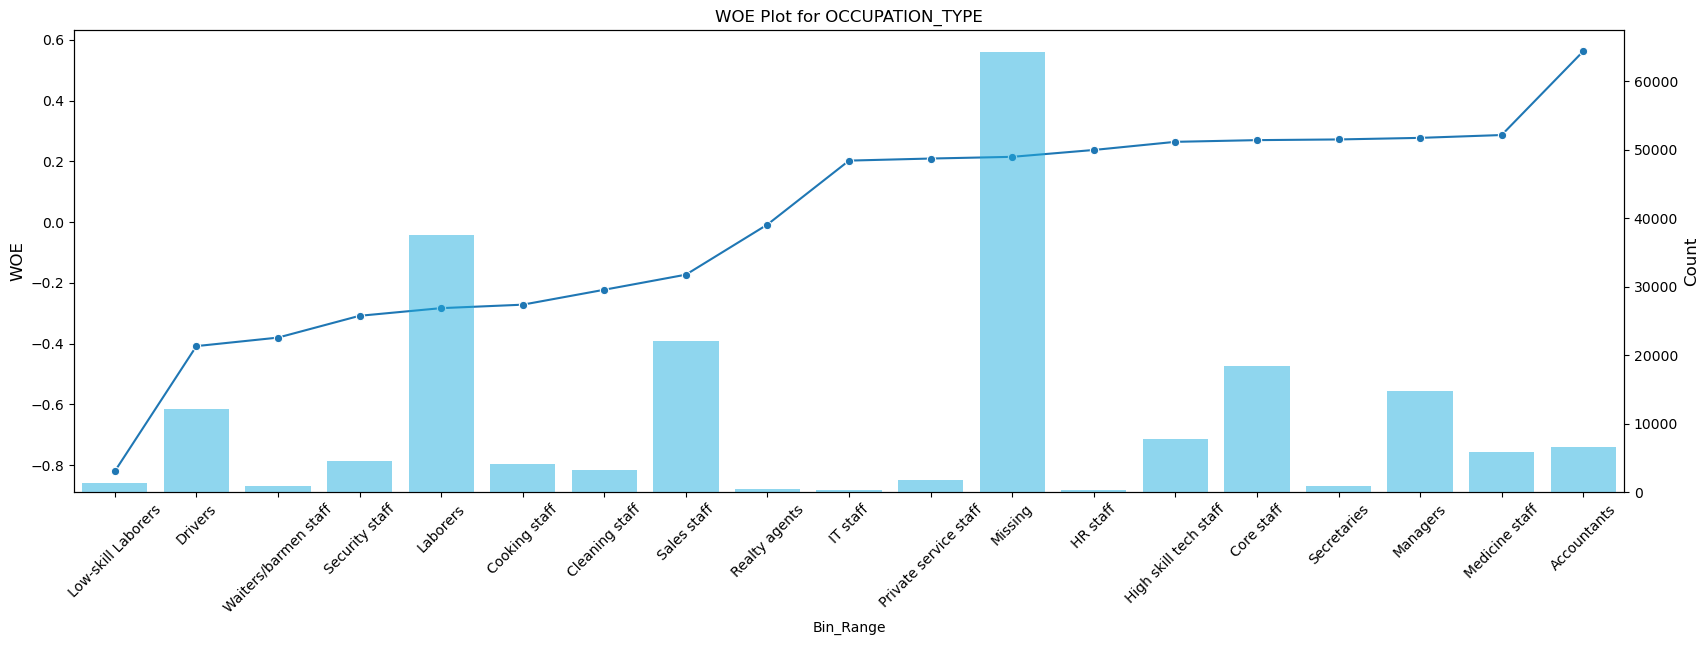

In [8]:
woe_iv_plot_categorical(final_df, "OCCUPATION_TYPE", target_name='TARGET')

IV for OCCUPATION_TYPE (grouped) with 4 bins: 0.0751

WOE values per grouped Bin_Range:
  Low-skill Laborers,Drivers,Waiters/barmen staff,Security staff: WOE = -0.419055
  Laborers: WOE = -0.283060
  Cooking staff,Cleaning staff,Sales staff,Realty agents: WOE = -0.189812
  IT staff,Private service staff,Missing,HR staff,High skill tech staff,Core staff,Secretaries,Managers,Medicine staff,Accountants: WOE = 0.254144


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

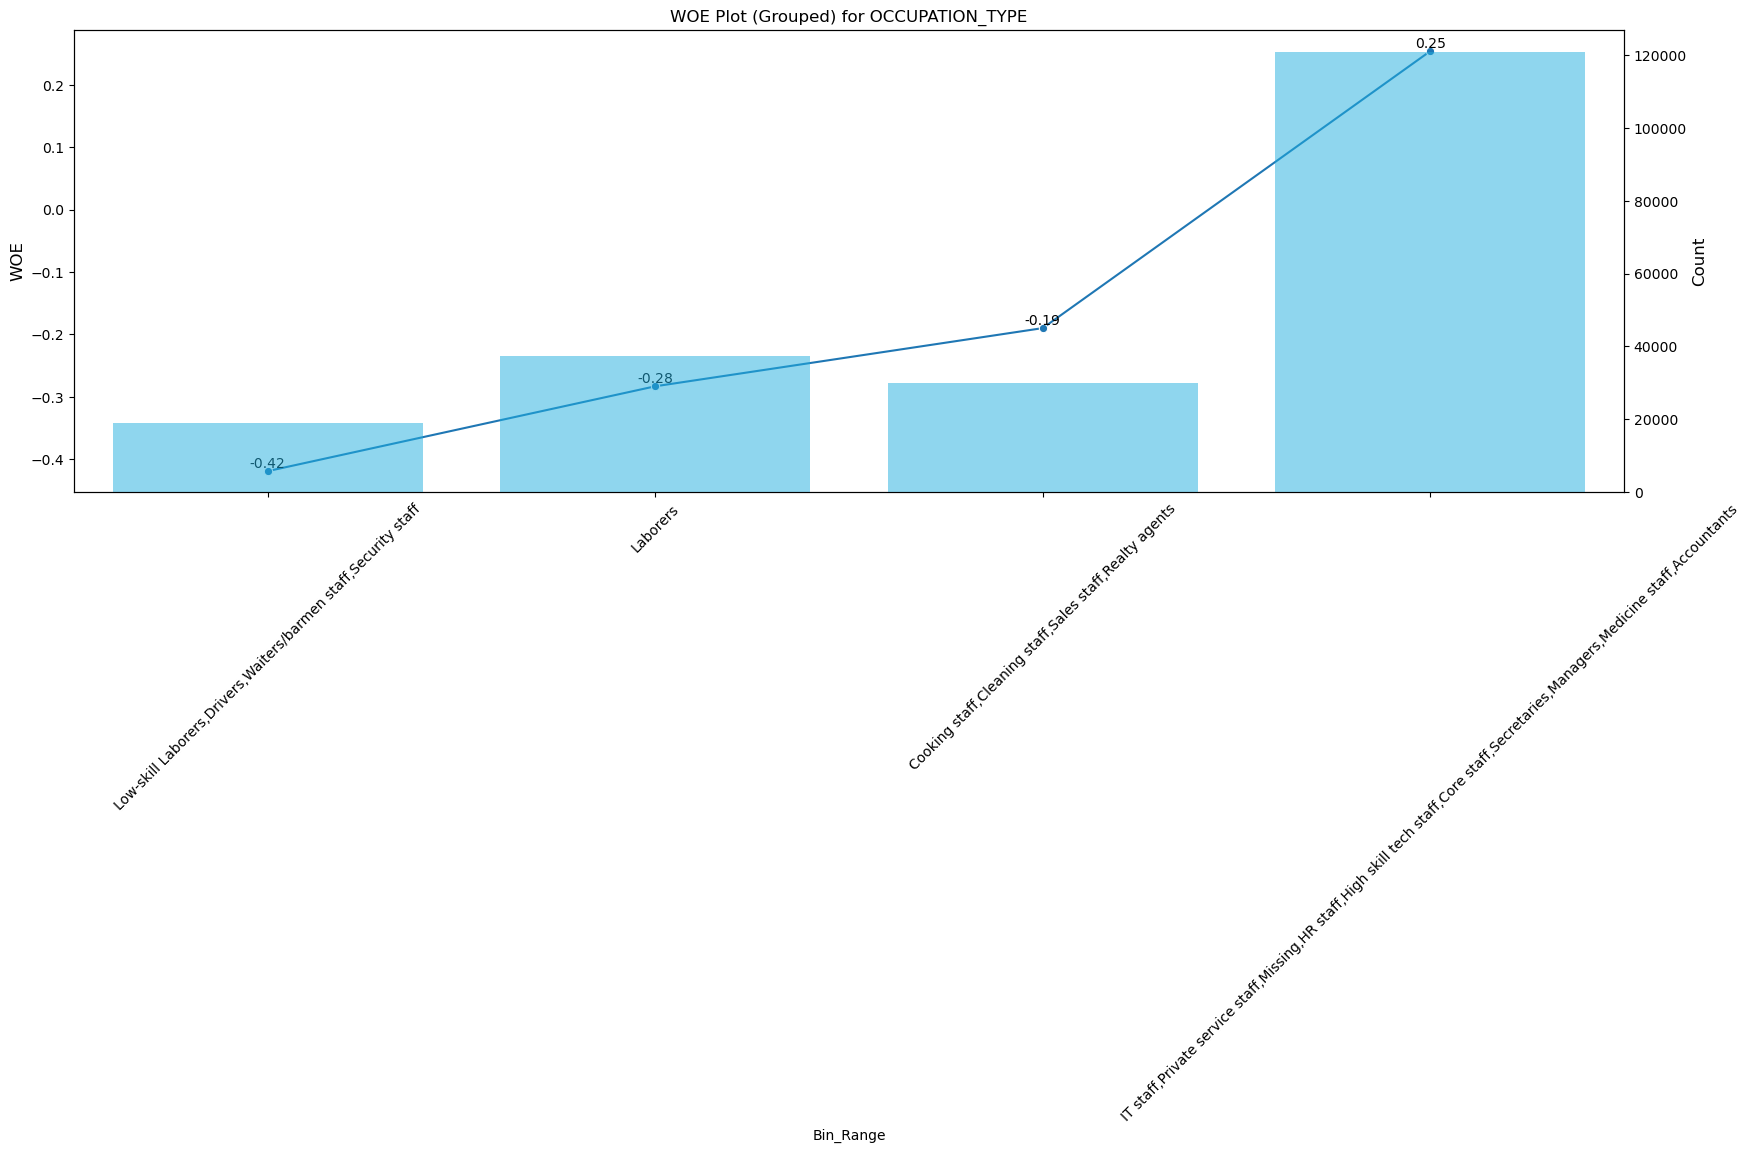

In [9]:
woe_iv_plot_categorical_manual(final_df, "OCCUPATION_TYPE", [0,4,5,9,19], target_name='TARGET')

/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

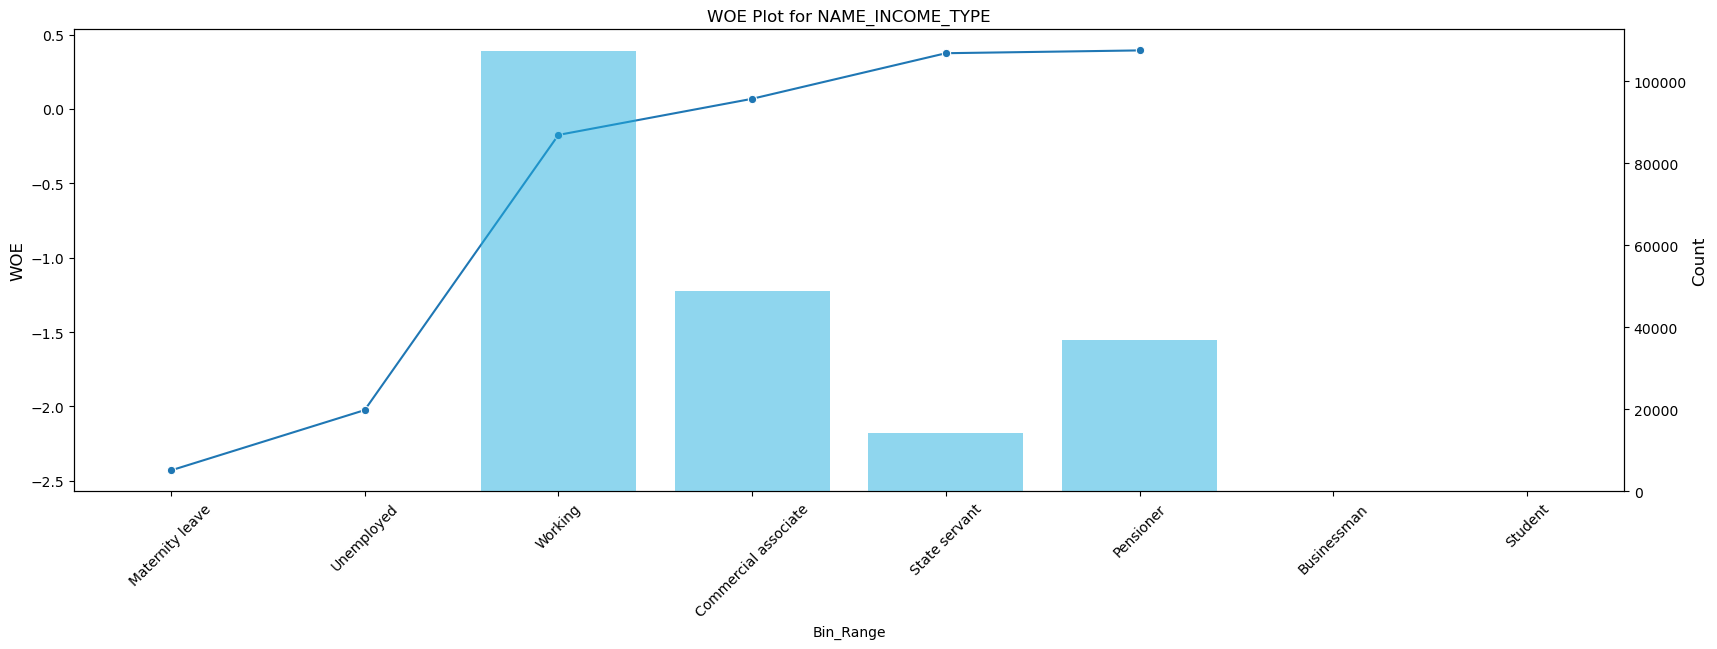

In [10]:
woe_iv_plot_categorical(final_df, "NAME_INCOME_TYPE", target_name='TARGET')

IV for NAME_INCOME_TYPE (grouped) with 3 bins: 0.0499

WOE values per grouped Bin_Range:
  Maternity leave,Unemployed,Working: WOE = -0.174844
  Commercial associate: WOE = 0.068848
  State servant,Pensioner,Businessman,Student: WOE = 0.389270


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

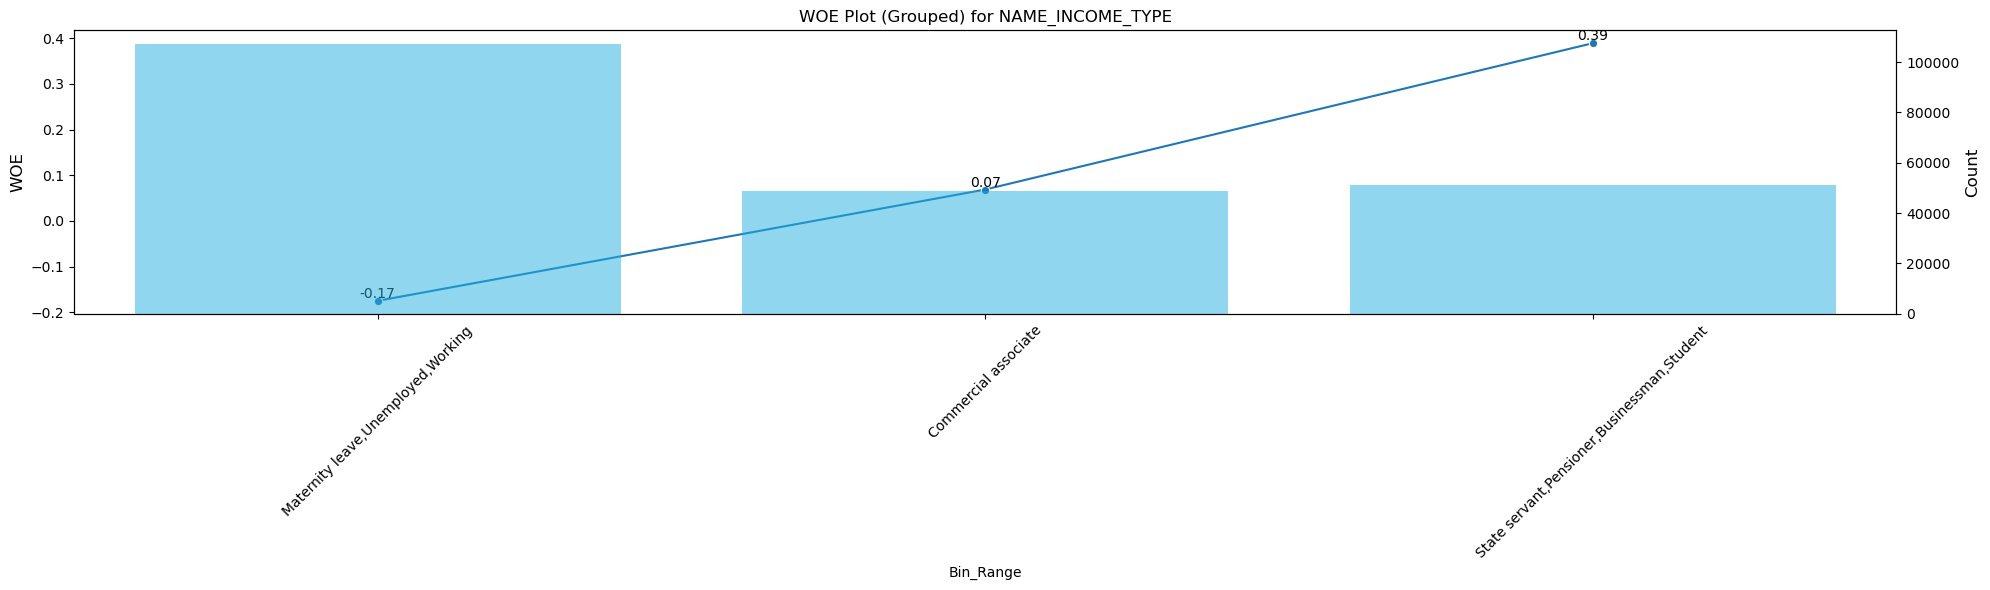

In [11]:
woe_iv_plot_categorical_manual(final_df, "NAME_INCOME_TYPE", [0,3,4,8], target_name='TARGET')

/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

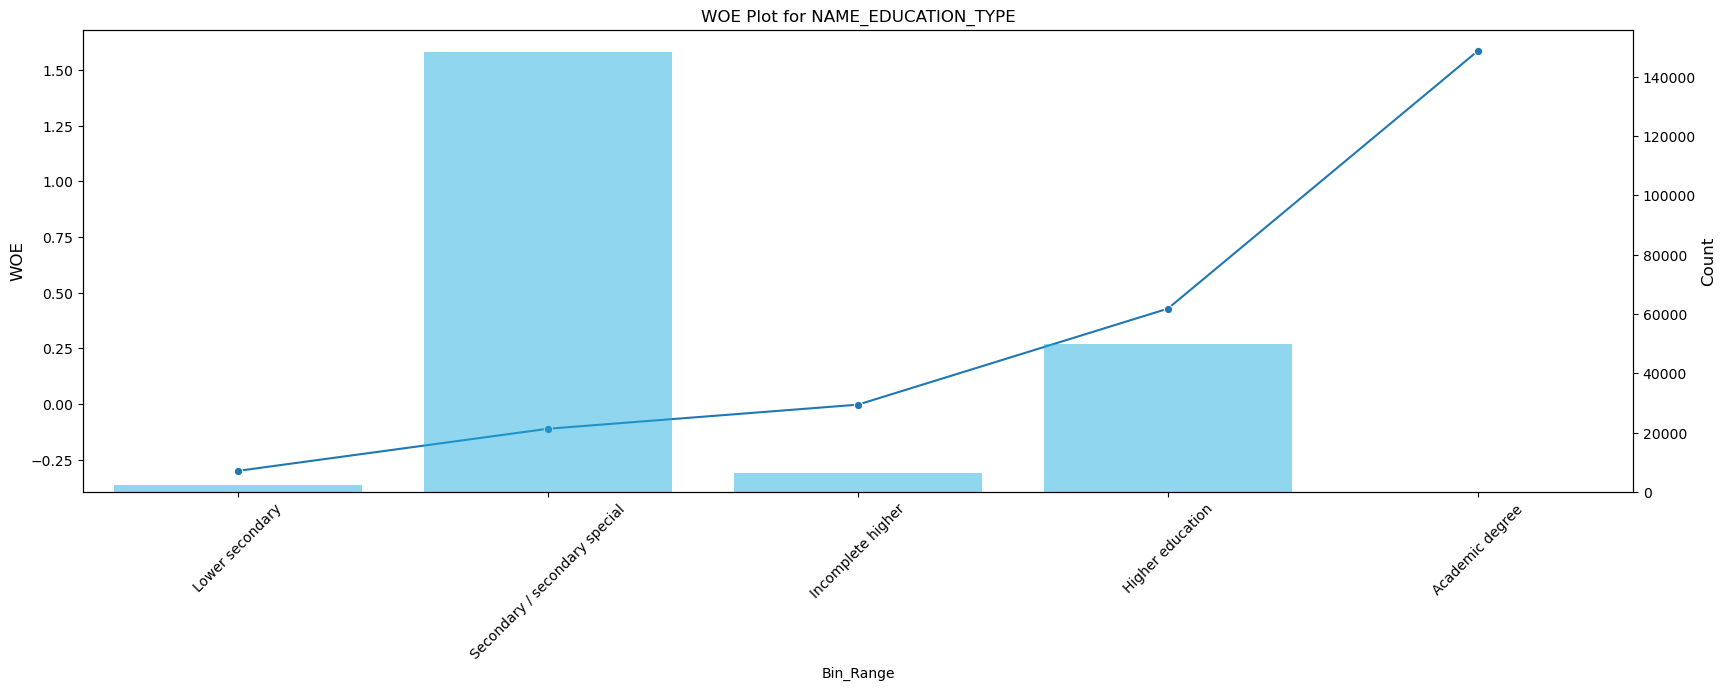

In [12]:
woe_iv_plot_categorical(final_df, "NAME_EDUCATION_TYPE", target_name='TARGET')

IV for NAME_EDUCATION_TYPE (grouped) with 2 bins: 0.0469

WOE values per grouped Bin_Range:
  Lower secondary,Secondary / secondary special,Incomplete higher: WOE = -0.109445
  Higher education,Academic degree: WOE = 0.430333


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

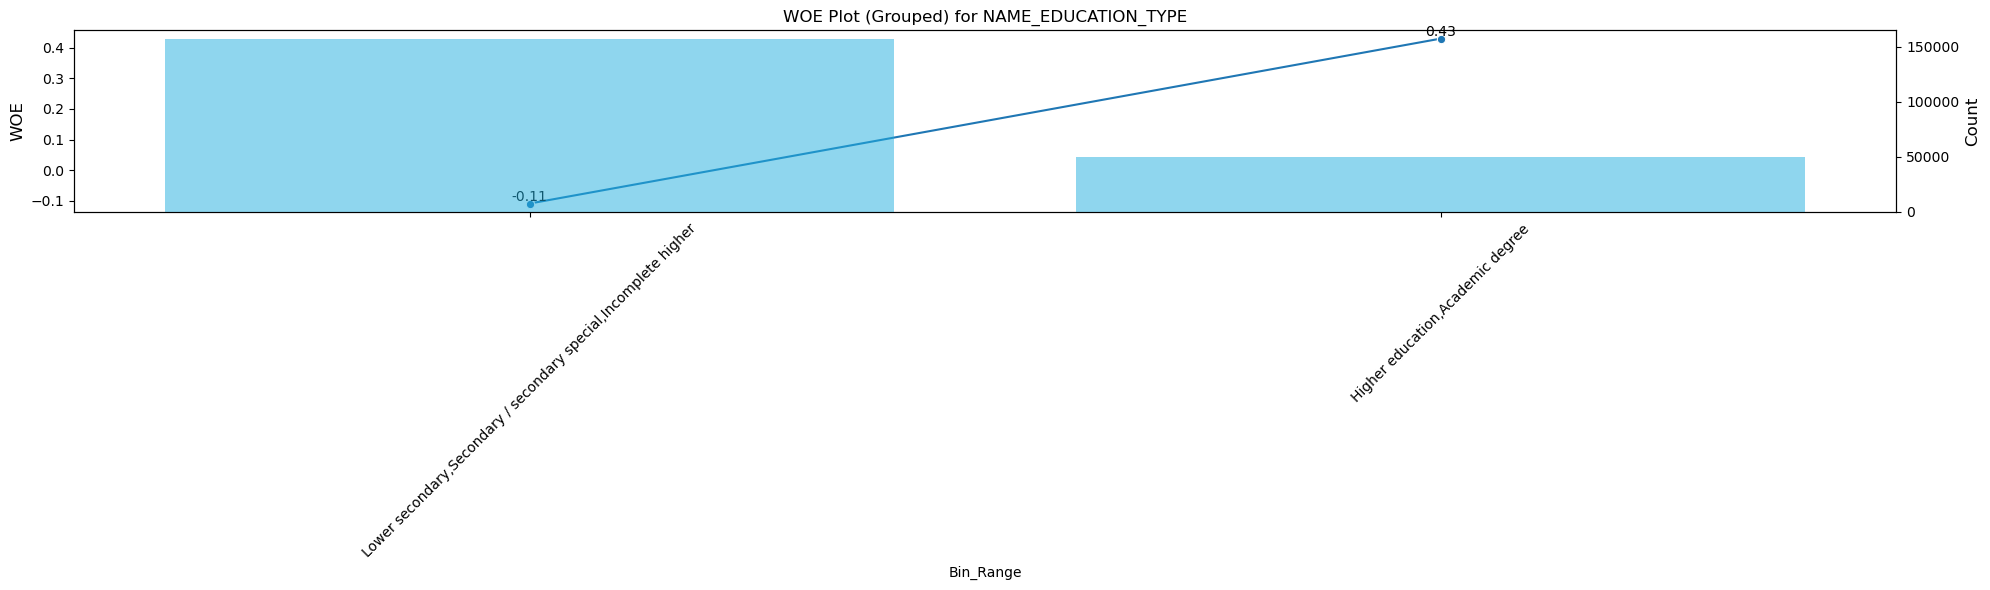

In [13]:
woe_iv_plot_categorical_manual(final_df, "NAME_EDUCATION_TYPE", [0,3,5], target_name='TARGET')

/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

IV for LIVINGAREA_MEDI with 21 bins: 0.034


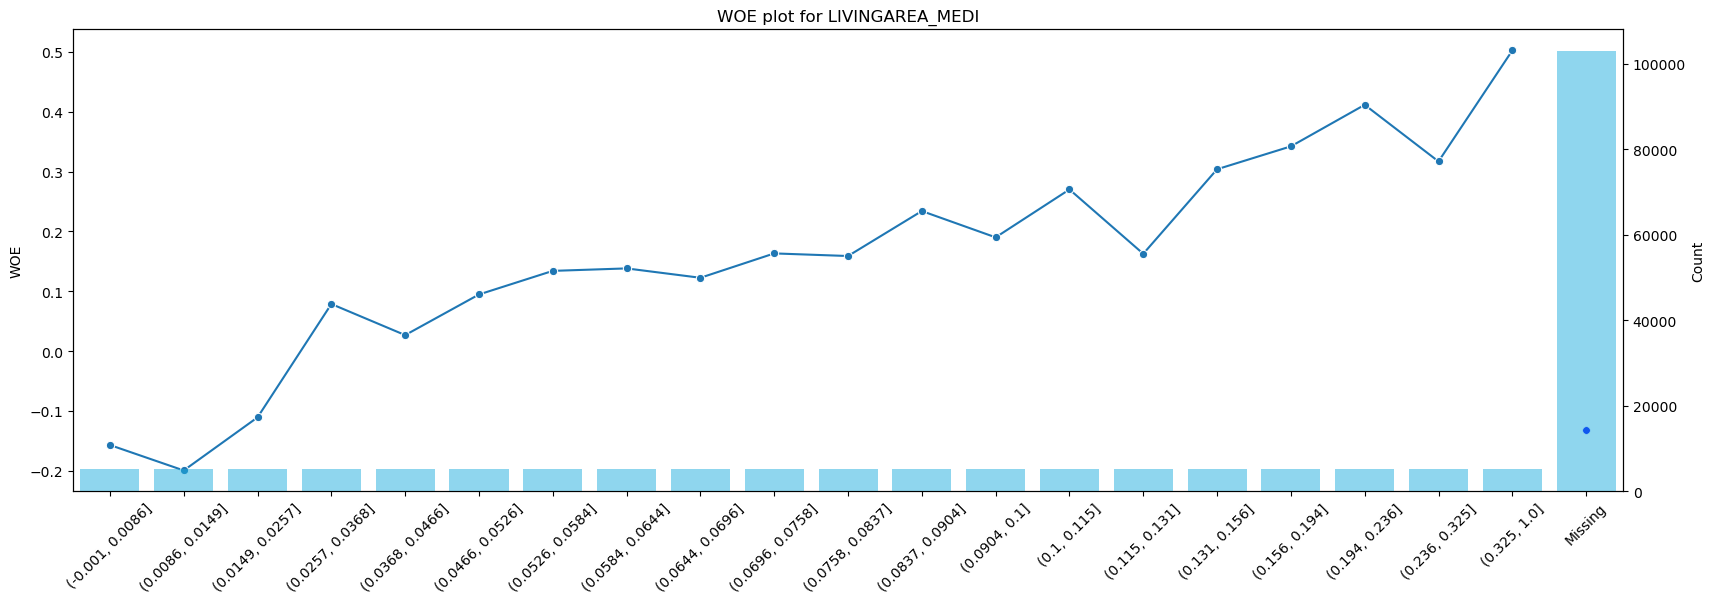

In [16]:
plot_numeric_woe(final_df, 'LIVINGAREA_MEDI', 20)


IV for LIVINGAREA_MEDI with 5 bins: 0.031
WOE values per Bin_Range:
  Missing: WOE = -0.131717
  (-0.002, 0.05]: WOE = -0.069361
  (0.05, 0.07]: WOE = 0.133419
  (0.07, 0.2]: WOE = 0.231519
  (0.2, 1.0]: WOE = 0.403904
IV for LIVINGAREA_MEDI with 5 bins: 0.031


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

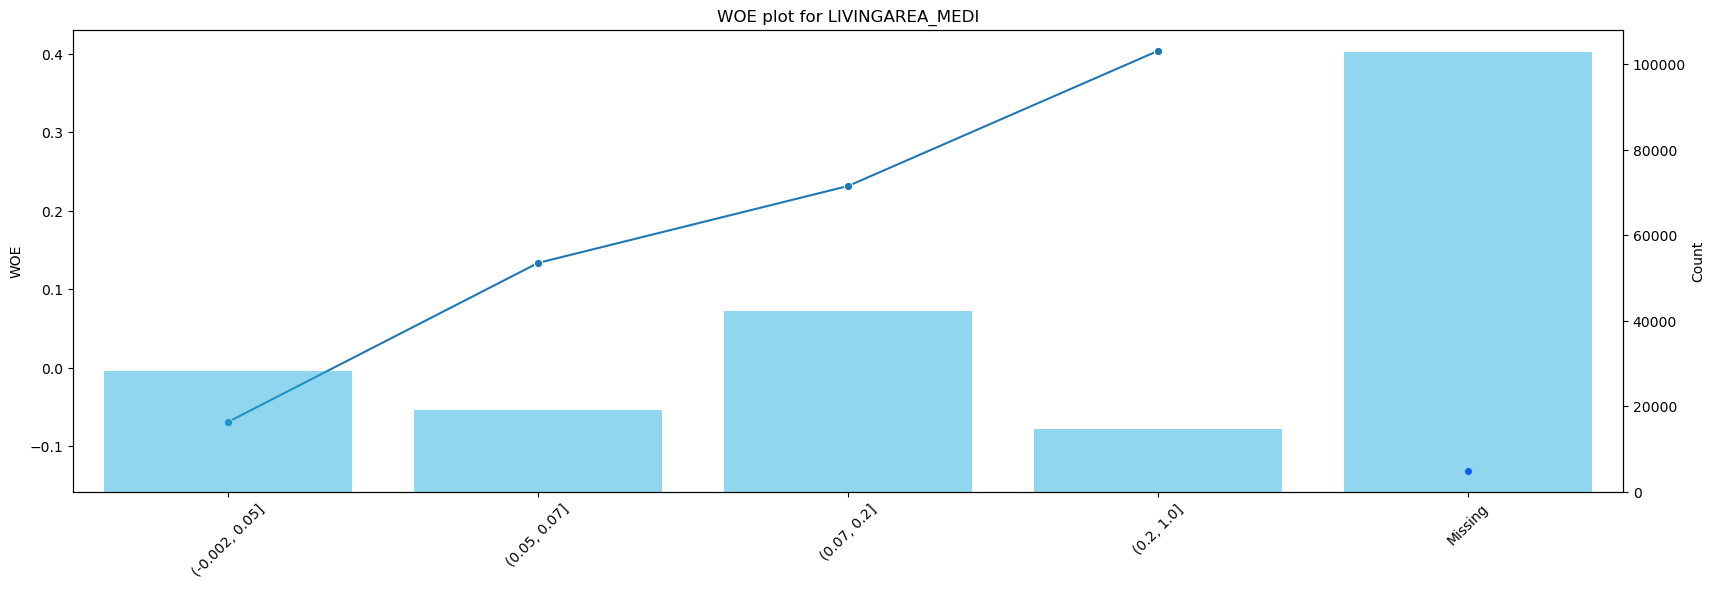

In [66]:
plot_numeric_woe_manual(final_df, 'LIVINGAREA_MEDI', [-0.001, 0.0500,0.0700,0.2,  1])


IV for TOTALAREA_MODE with 21 bins: 0.0367


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

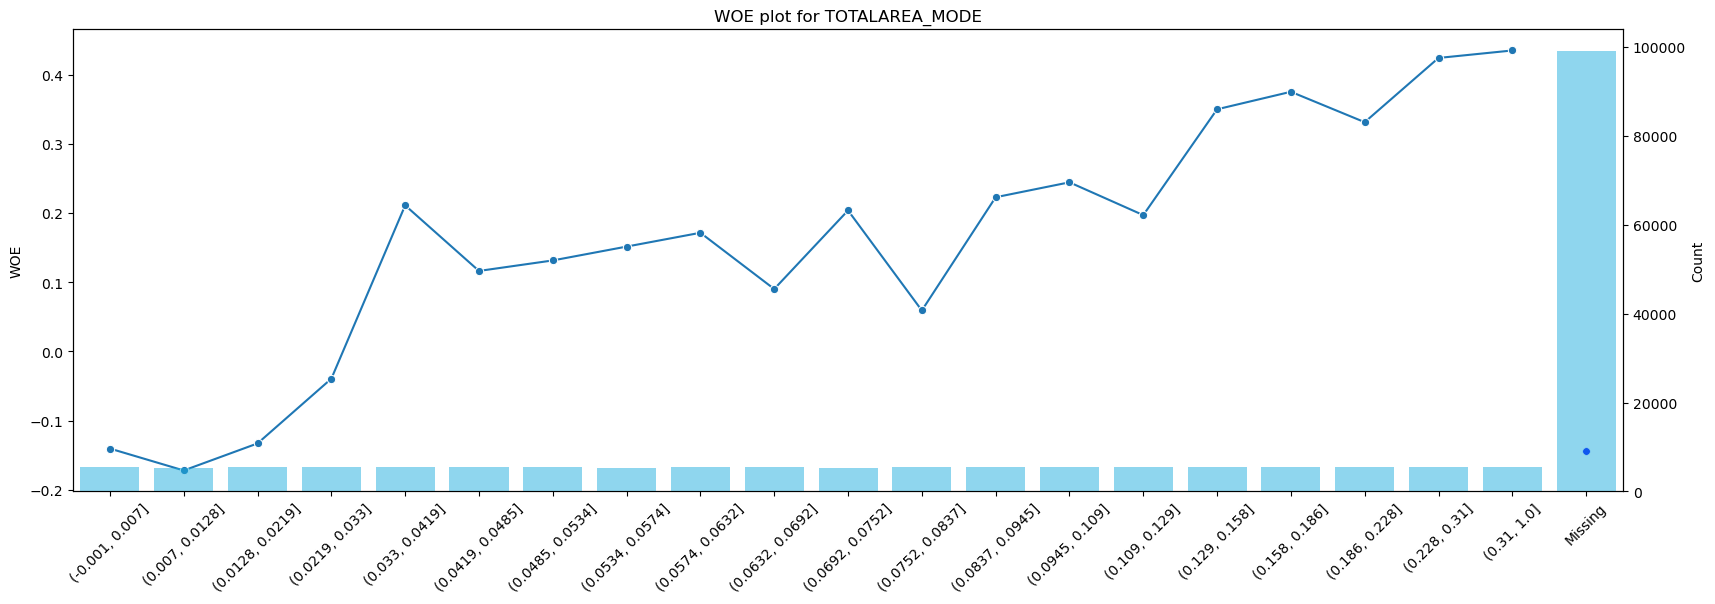

In [19]:
plot_numeric_woe(final_df, 'TOTALAREA_MODE', 20)


IV for TOTALAREA_MODE with 5 bins: 0.0348
WOE values per Bin_Range:
  Missing: WOE = -0.141933
  (-0.011, 0.03]: WOE = -0.131373
  (0.03, 0.08]: WOE = 0.135893
  (0.08, 0.2]: WOE = 0.263174
  (0.2, 0.7]: WOE = 0.418768
IV for TOTALAREA_MODE with 5 bins: 0.0348


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

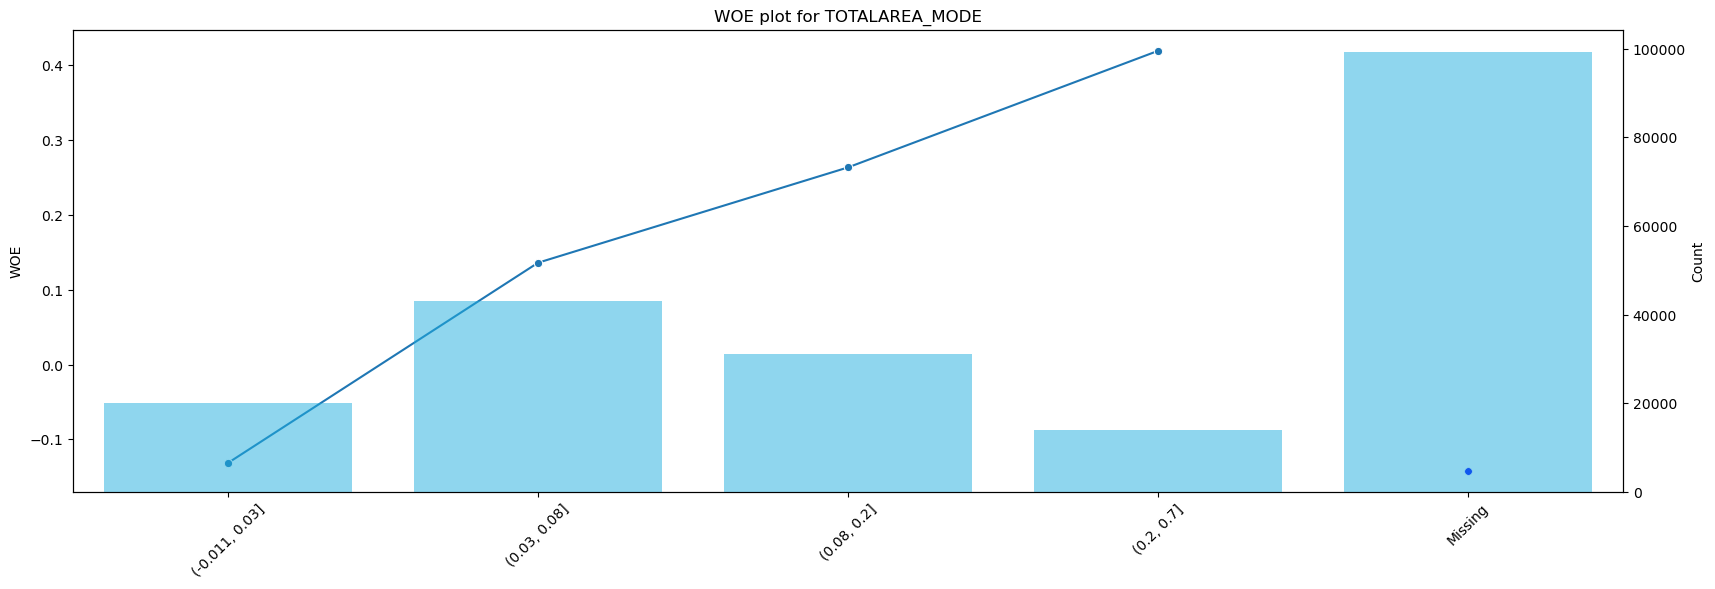

In [65]:
plot_numeric_woe_manual(final_df, 'TOTALAREA_MODE', [-0.01,0.03, 0.08, 0.2, 0.7])


IV for DAYS_LAST_PHONE_CHANGE with 19 bins: inf


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

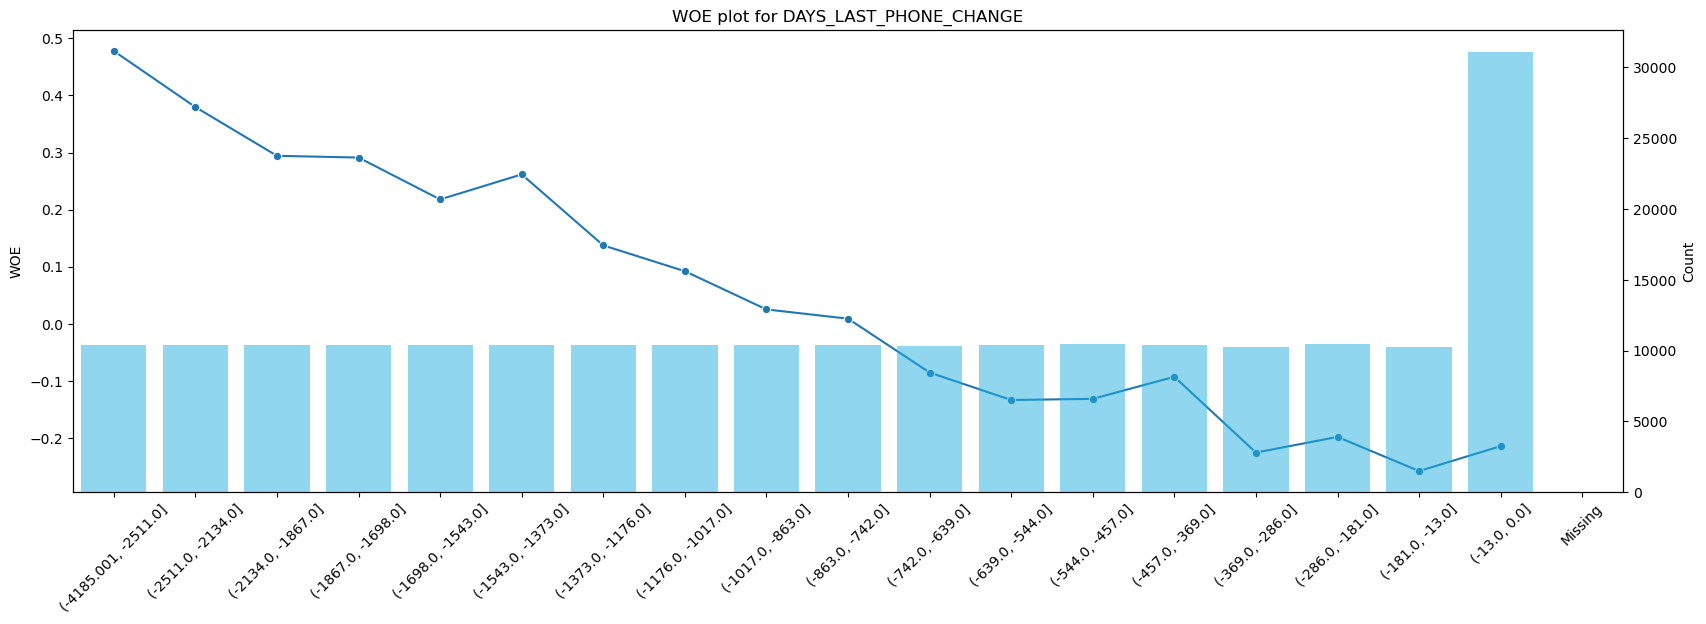

In [23]:
plot_numeric_woe(final_df, 'DAYS_LAST_PHONE_CHANGE', 20)


IV for DAYS_LAST_PHONE_CHANGE with 5 bins: 0.0461
WOE values per Bin_Range:
  Missing: WOE = -0.209905
  (-750.0, -10.0]: WOE = -0.162374
  (-1400.0, -750.0]: WOE = 0.067069
  (-2100.0, -1400.0]: WOE = 0.265045
  (-4200.001, -2100.0]: WOE = 0.429721
IV for DAYS_LAST_PHONE_CHANGE with 5 bins: 0.0461


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

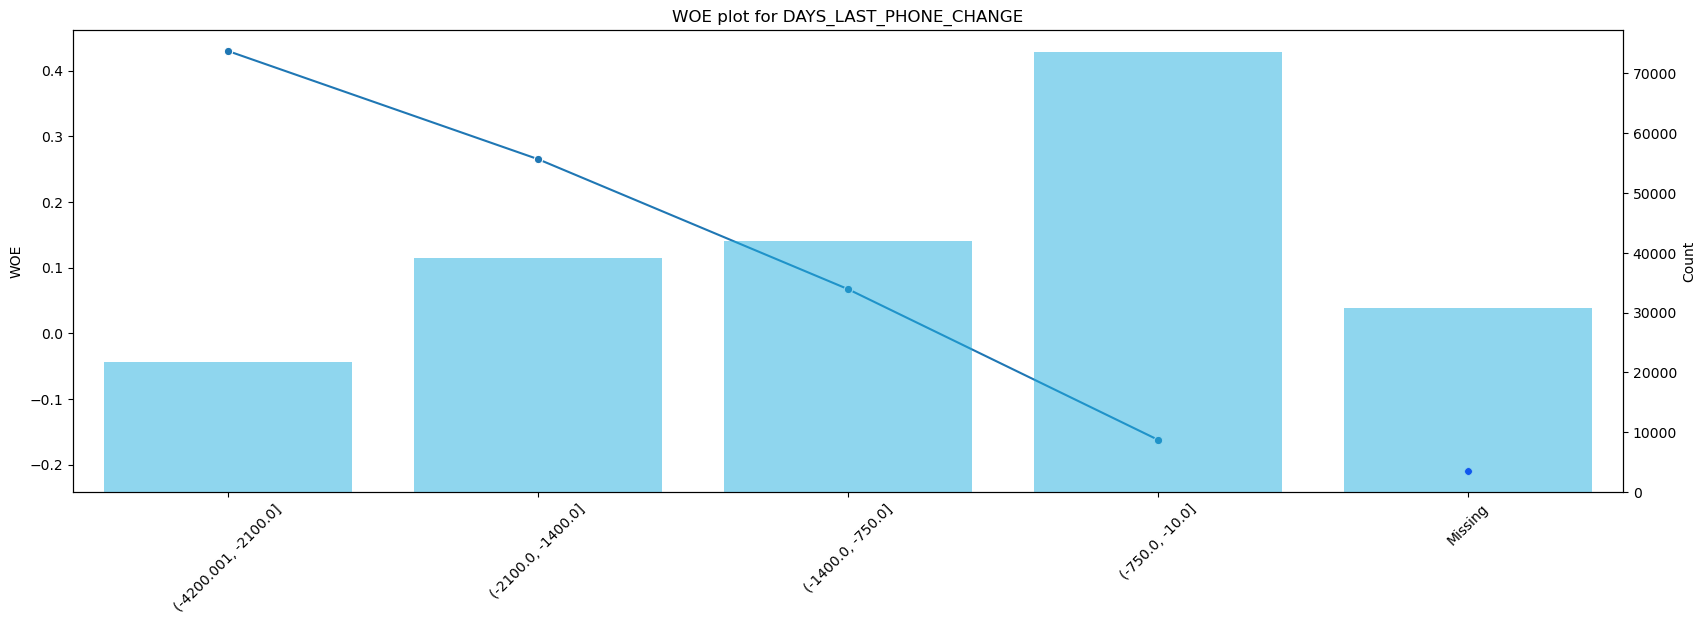

In [57]:
plot_numeric_woe_manual(final_df, 'DAYS_LAST_PHONE_CHANGE', [-4200,-2100, -1400, -750, -10])


IV for RATIO_LIFE_EMPLOYED with 20 bins: 0.0883


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

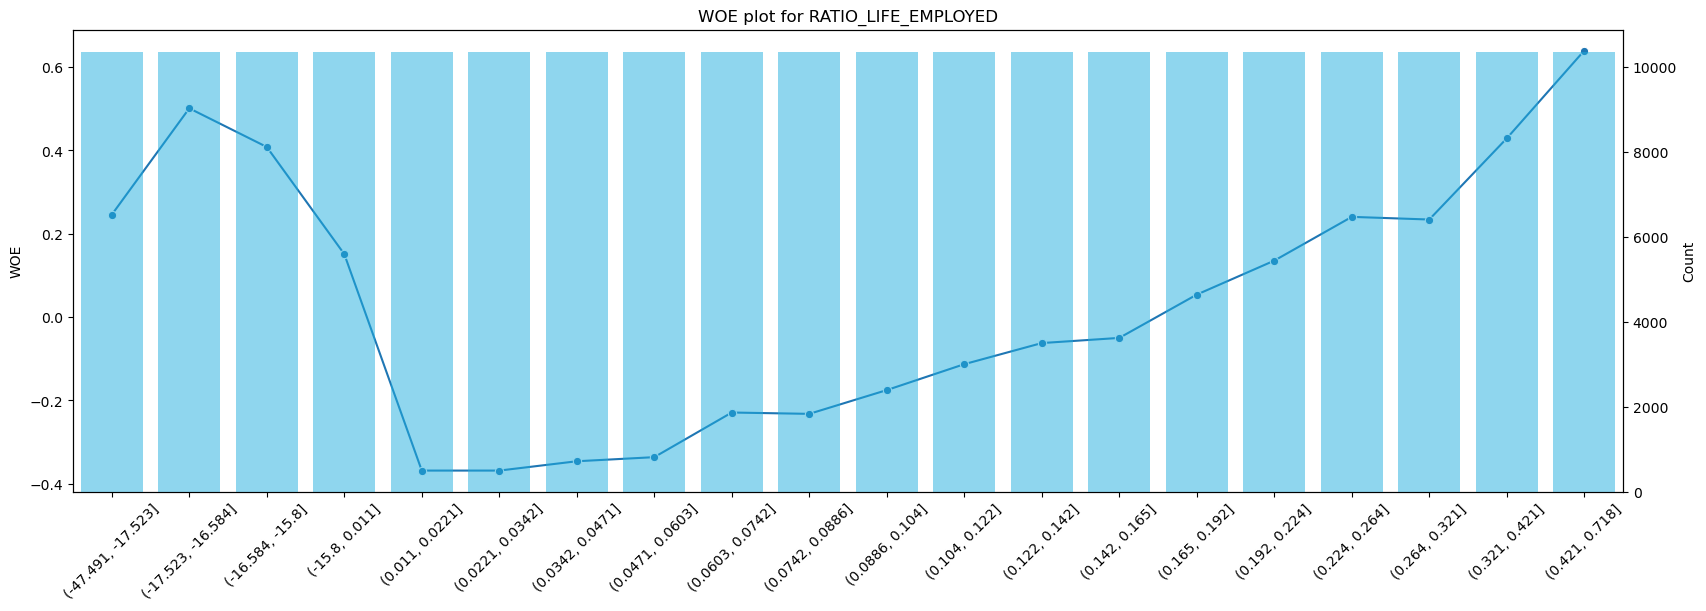

In [26]:
plot_numeric_woe(final_df, 'RATIO_LIFE_EMPLOYED', 20)


IV for RATIO_LIFE_EMPLOYED with 6 bins: 0.0802
WOE values per Bin_Range:
  (0.01, 0.07]: WOE = -0.333360
  (0.07, 0.12]: WOE = -0.185391
  (0.12, 0.19]: WOE = -0.023605
  (0.19, 0.22]: WOE = 0.128232
  (-47.001, 0.01]: WOE = 0.332841
  Missing: WOE = 0.369060
IV for RATIO_LIFE_EMPLOYED with 6 bins: 0.0802


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

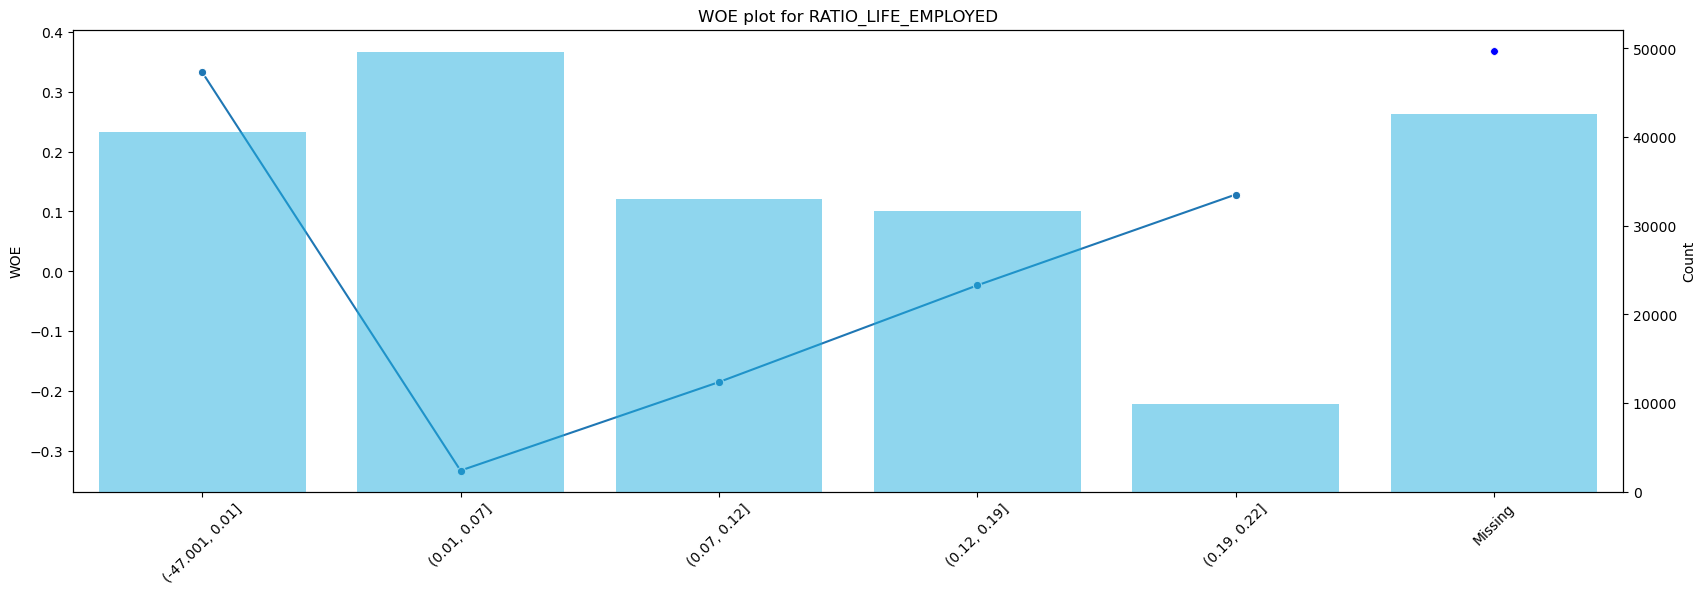

In [56]:
plot_numeric_woe_manual(final_df, 'RATIO_LIFE_EMPLOYED', [-47,0.01, 0.07, 0.12,0.19,0.22])

IV for LOAN_TO_VALUE with 15 bins: 0.0919


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

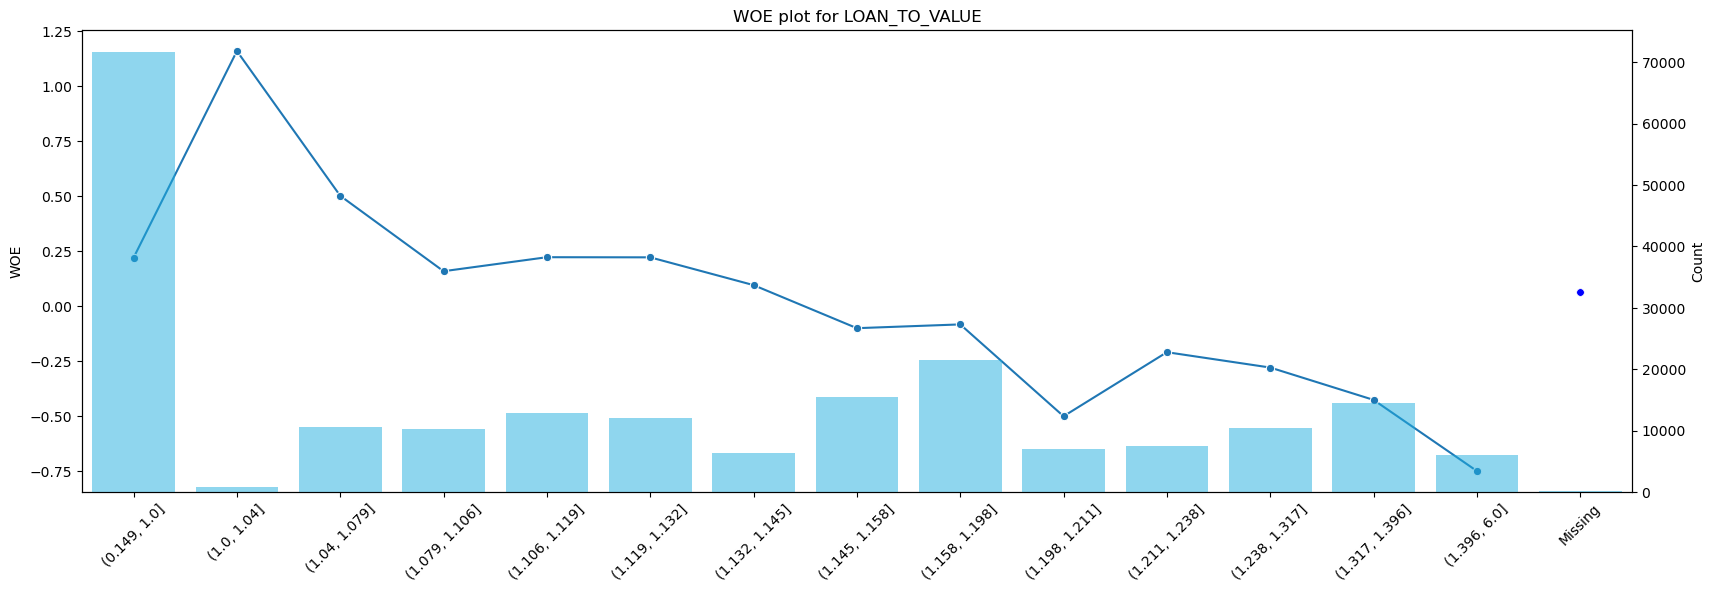

In [31]:

plot_numeric_woe(final_df, 'LOAN_TO_VALUE', 20)


IV for LOAN_TO_VALUE with 5 bins: 0.0687
WOE values per Bin_Range:
  (1.3, 6.0]: WOE = -0.525036
  (1.2, 1.3]: WOE = -0.327918
  Missing: WOE = 0.064704
  (1.0, 1.2]: WOE = 0.099447
  (0.149, 1.0]: WOE = 0.219236
IV for LOAN_TO_VALUE with 5 bins: 0.0687


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

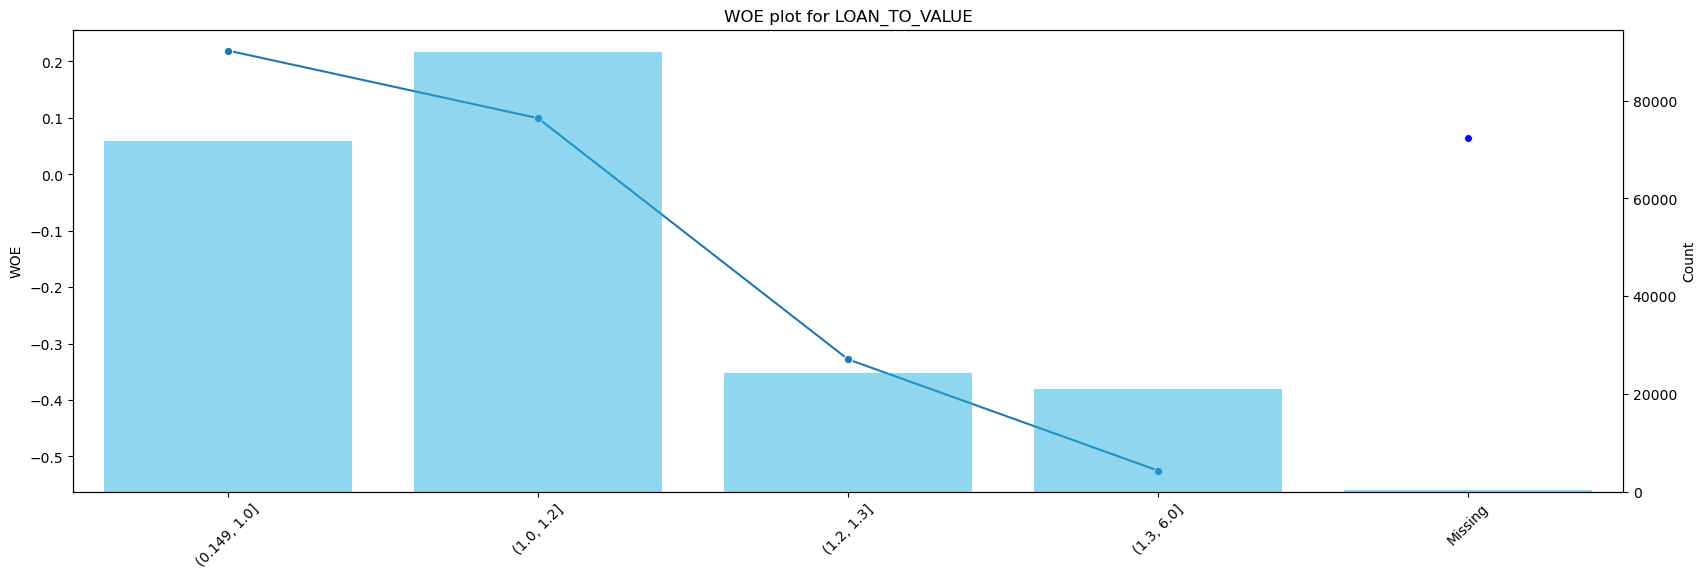

In [55]:
plot_numeric_woe_manual(final_df, 'LOAN_TO_VALUE', [0.15,1,1.2, 1.3, 6])

IV for DAYS_CREDIT_min with 21 bins: 0.0786


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

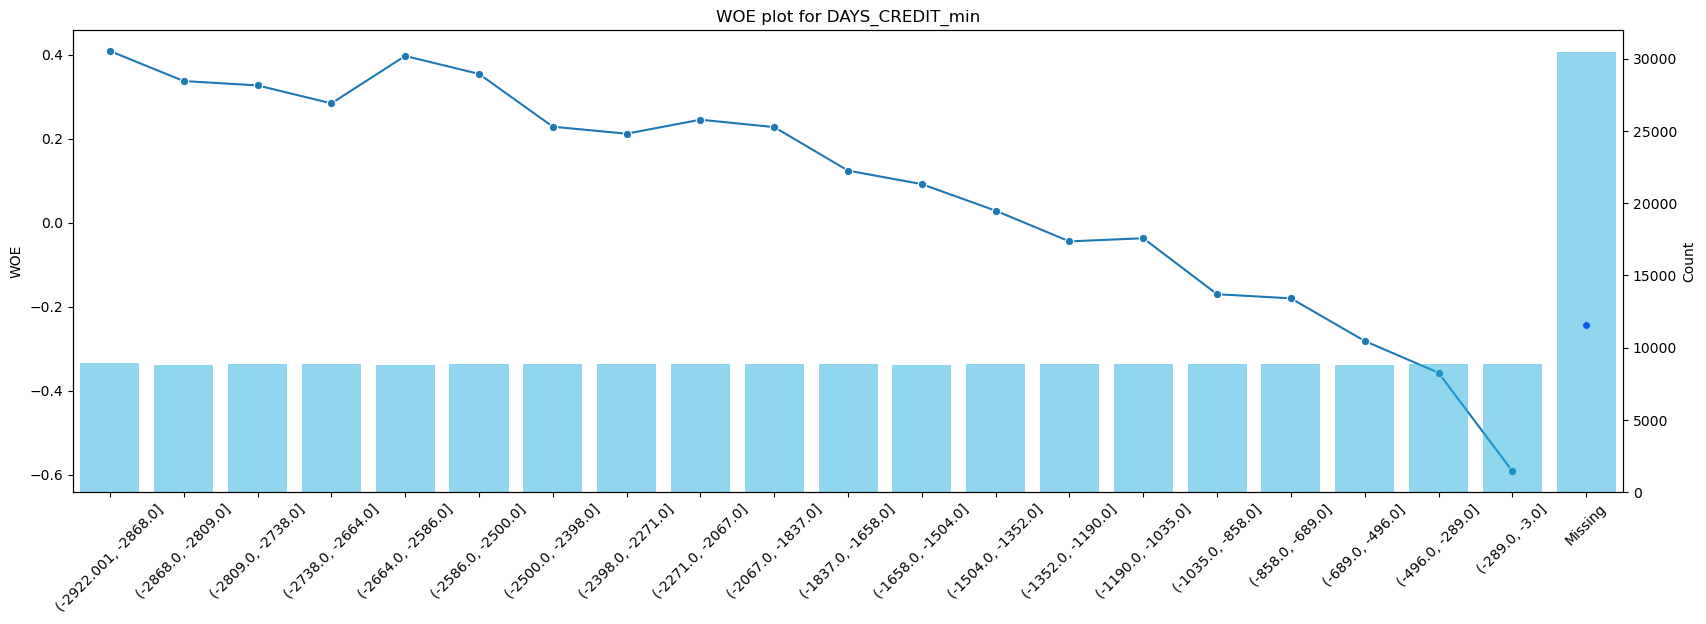

In [42]:

plot_numeric_woe(final_df, 'DAYS_CREDIT_min', 20)


IV for DAYS_CREDIT_min with 5 bins: 0.0638
WOE values per Bin_Range:
  (-1000.0, -200.0]: WOE = -0.285152
  Missing: WOE = -0.259793
  (-1500.0, -1000.0]: WOE = -0.025217
  (-2500.0, -1500.0]: WOE = 0.186869
  (-2900.001, -2500.0]: WOE = 0.346267
IV for DAYS_CREDIT_min with 5 bins: 0.0638


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

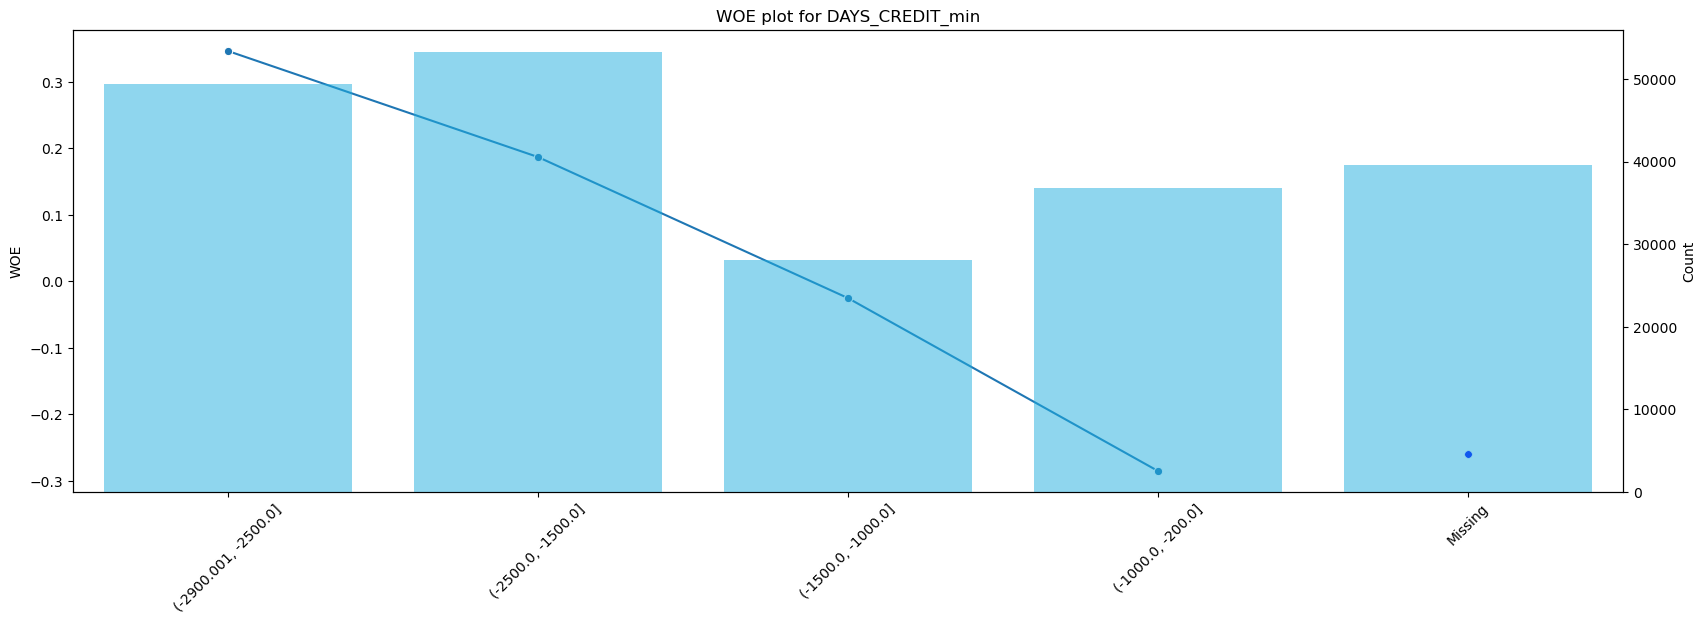

In [54]:
plot_numeric_woe_manual(final_df, 'DAYS_CREDIT_min', [-2900,-2500,-1500, -1000, -200])

IV for DAYS_CREDIT_ENDDATE_mean with 21 bins: 0.0755


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

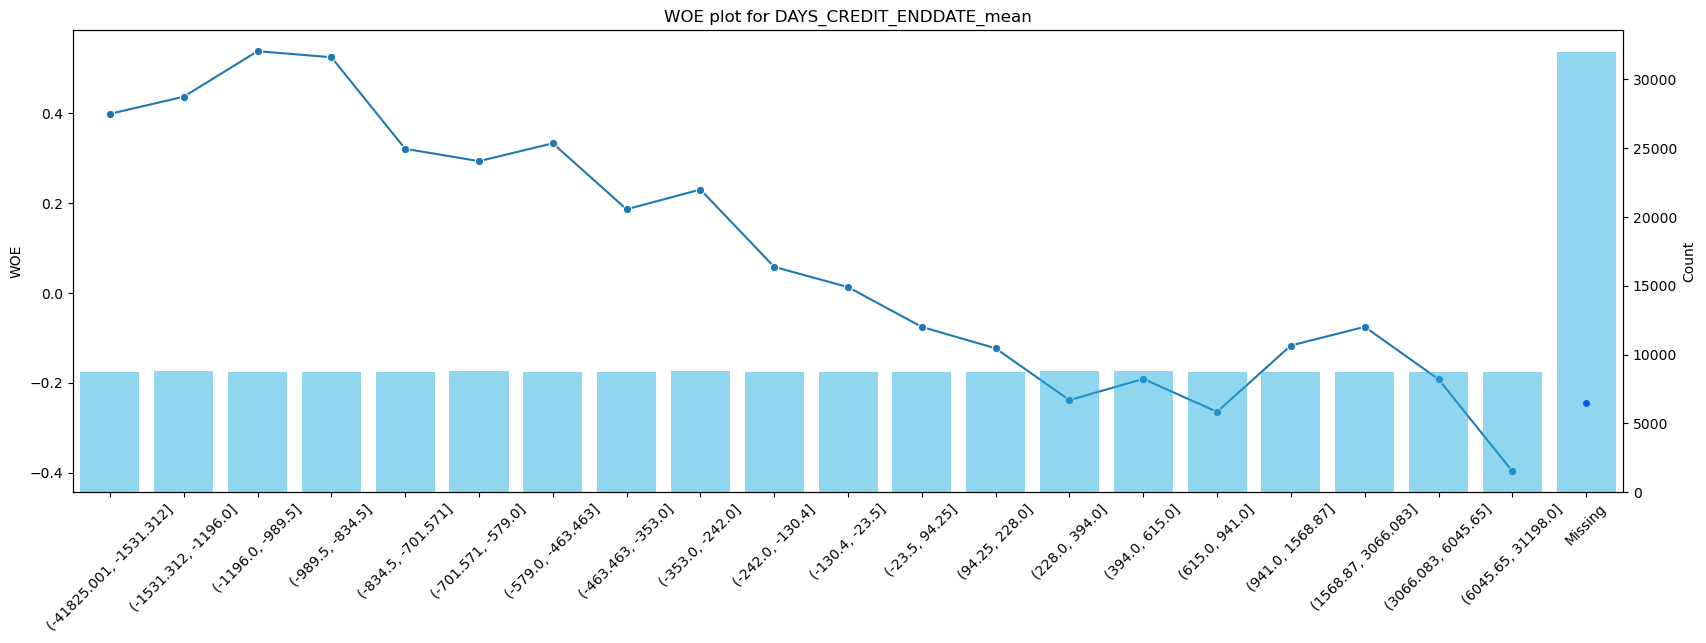

In [44]:

plot_numeric_woe(final_df, 'DAYS_CREDIT_ENDDATE_mean', 20)



IV for DAYS_CREDIT_ENDDATE_mean with 5 bins: 0.0704
WOE values per Bin_Range:
  Missing: WOE = -0.244321
  (200.0, 32000.0]: WOE = -0.217049
  (-200.0, 200.0]: WOE = -0.037639
  (-500.0, -200.0]: WOE = 0.216523
  (-41800.001, -500.0]: WOE = 0.406608
IV for DAYS_CREDIT_ENDDATE_mean with 5 bins: 0.0704


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

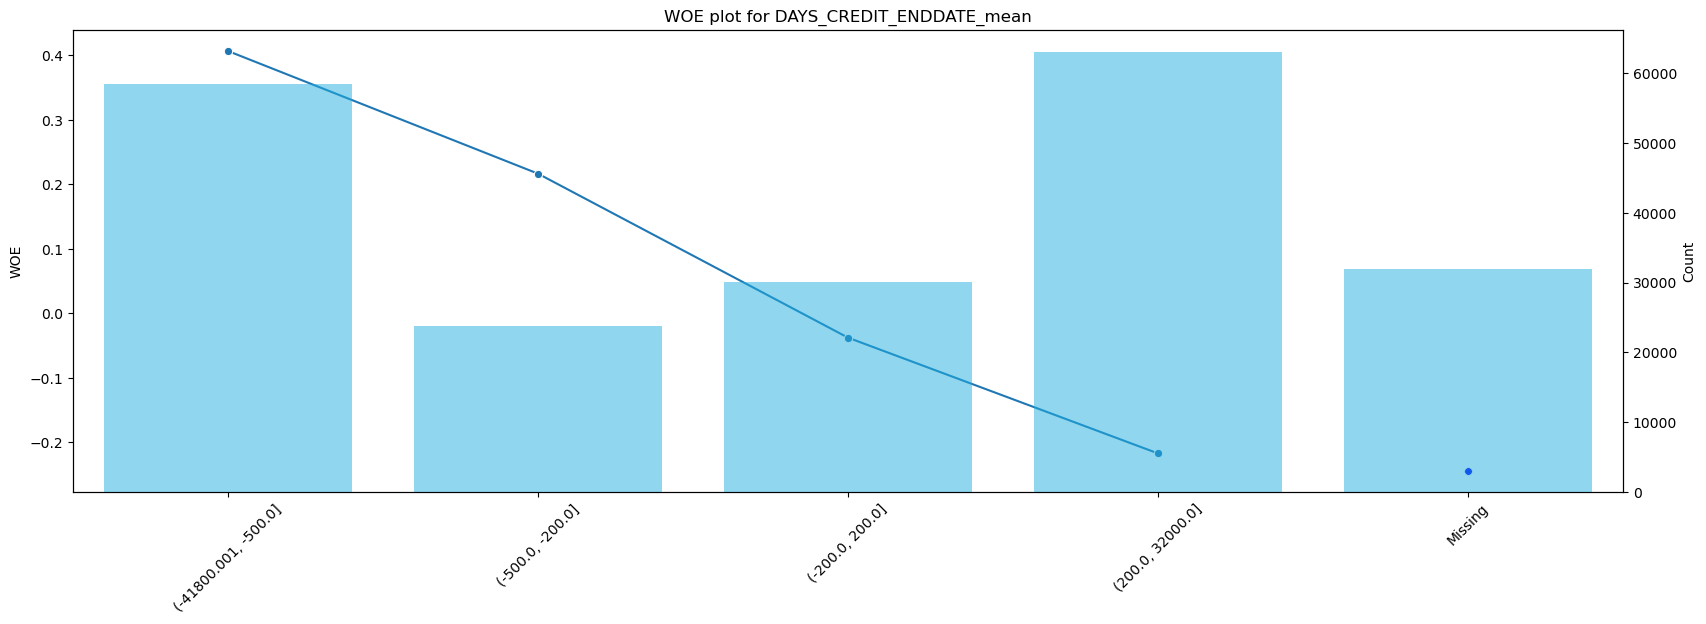

In [53]:
plot_numeric_woe_manual(final_df, 'DAYS_CREDIT_ENDDATE_mean', [-41800,-500,-200, 200, 32000])

IV for DAYS_ENDDATE_FACT_min with 15 bins: 0.0666


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

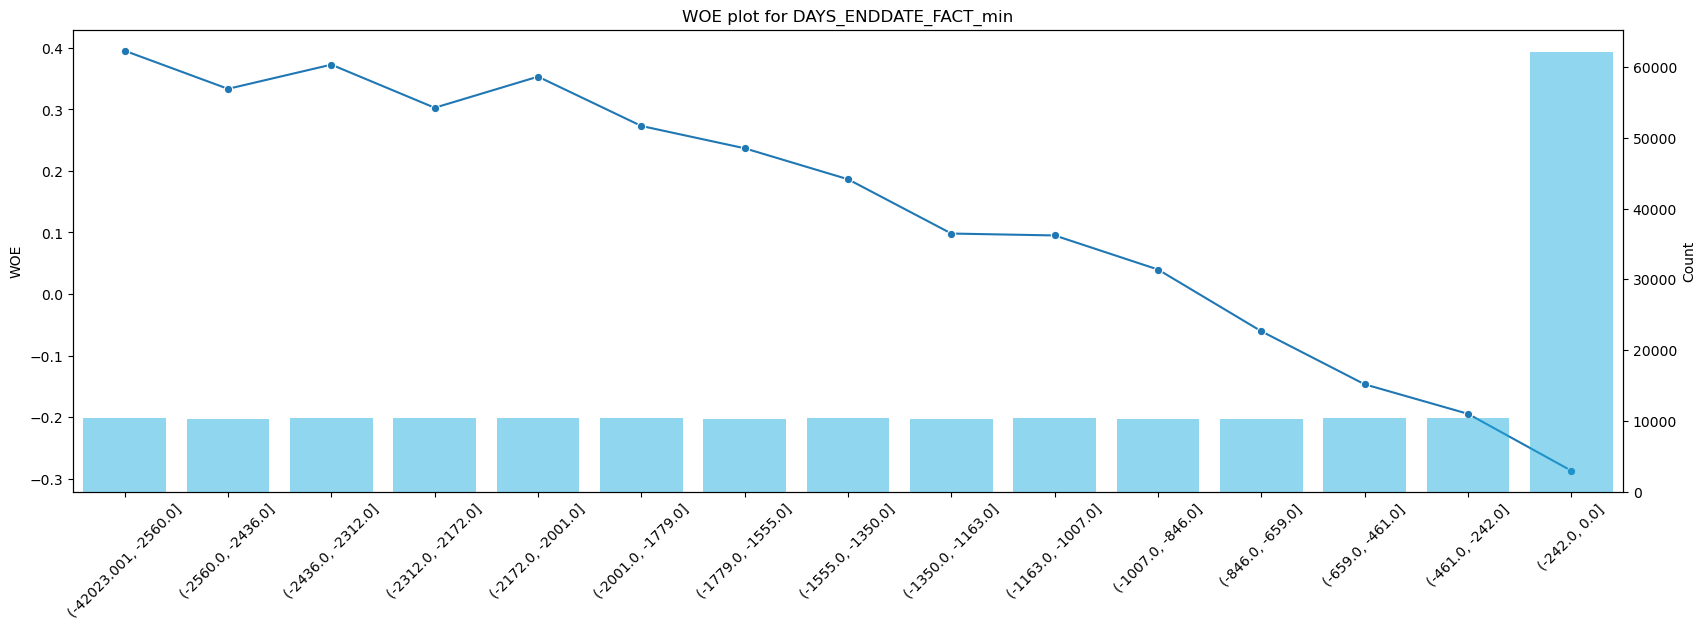

In [68]:
plot_numeric_woe(final_df, 'DAYS_ENDDATE_FACT_min', 20)


IV for DAYS_ENDDATE_FACT_min with 5 bins: 0.0647
WOE values per Bin_Range:
  Missing: WOE = -0.285875
  (-800.0, -200.0]: WOE = -0.151864
  (-1200.0, -800.0]: WOE = 0.049462
  (-2000.0, -1200.0]: WOE = 0.204397
  (-43000.001, -2000.0]: WOE = 0.351545
IV for DAYS_ENDDATE_FACT_min with 5 bins: 0.0647


/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sweekiatwong/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

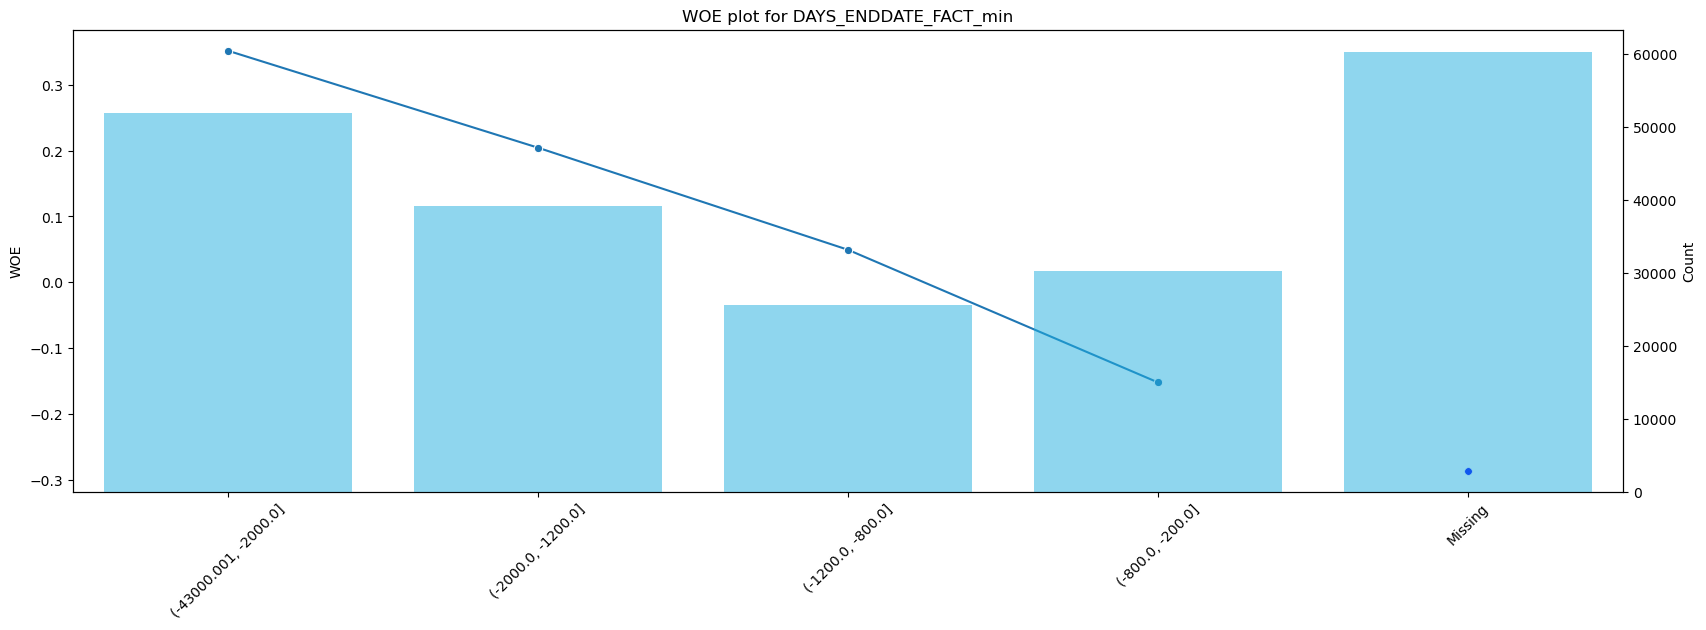

In [69]:
plot_numeric_woe_manual(final_df, 'DAYS_ENDDATE_FACT_min', [-43000,-2000,-1200, -800, -200])

<h2> WOE Encoding </h2>

In [70]:
encoded_df = pd.DataFrame()

In [ ]:
def Encode_WOE_categorical(column, bin_ranges, woe_values, output_df, missing_woe_value):
    """
    Encode a categorical column into WOE using manual groupings and handle missing values.
    
    Parameters:
    - column: pandas Series (e.g. original_df['JOB'])
    - bin_ranges: list of grouped category strings (e.g., ['student,unemployed', 'working'])
    - woe_values: WOE values for each group (e.g., [-0.2, 0.4])
    - output_df: DataFrame to which the new column will be added
    - missing_woe_value: WOE value to assign to missing or unmapped values
    """
    col_name = column.name + '_woe'

    # Step 1: Build category-to-WOE mapping
    group_to_woe = {}
    for group_str, woe_val in zip(bin_ranges, woe_values):
        categories = [cat.strip() for cat in group_str.split(',')]
        for cat in categories:
            group_to_woe[cat] = float(woe_val)

    # Step 2: Map values and handle missing/unmapped
    encoded_col = column.fillna('Missing').astype(str).map(group_to_woe).fillna(float(missing_woe_value))

    # Step 3: Add to output DataFrame
    output_df[col_name] = encoded_col

In [71]:
def Encode_WOE_numerical(column, bin_edges, woe_values, output_df, missing_woe_value):
    """
    Encode a numerical column into WOE using manual bins and handle missing values.

    Parameters:
    - column: pandas Series (e.g. original_df['EXT_SOURCE_1'])
    - bin_edges: list of numeric cut points
    - woe_values: WOE values for each bin (len = len(bin_edges) - 1)
    - output_df: DataFrame to which the encoded column will be added
    - missing_woe_value: WOE value to assign to missing values
    """
    col_name = column.name + '_woe'

    # Step 1: Bin the values
    binned = pd.cut(column, bins=bin_edges, include_lowest=True)

    # Step 2: Map each bin to WOE
    bin_labels = binned.cat.categories
    if len(woe_values) != len(bin_labels):
        raise ValueError(f"Number of WOE values ({len(woe_values)}) must match number of bins ({len(bin_labels)})")

    bin_to_woe = {bin_labels[i]: float(woe_values[i]) for i in range(len(woe_values))}

    # Step 3: Map and handle missing values
    encoded_col = binned.map(bin_to_woe).astype(float).fillna(float(missing_woe_value))

    # Step 4: Add to output DataFrame
    output_df[col_name] = encoded_col

In [ ]:
Encode_WOE_categorical(
    final_df['NAME_INCOME_TYPE'],
    bin_ranges=['Maternity leave,Unemployed,Working', 'Commercial associate' , 'State servant,Pensioner,Businessman,Student'],
    woe_values=[-0.174844, 0.068848, 0.389270],
    output_df=encoded_df,
    missing_woe_value=0.0
)
encoded_df.head(10)

,NAME_INCOME_TYPE_woe
0,-0.174844
1,-0.174844
2,-0.174844
3,-0.174844
4,0.389270
5,0.068848
6,0.389270
7,0.389270
8,-0.174844
9,-0.174844


In [ ]:
Encode_WOE_numerical(
    final_df['EXT_SOURCE_1'],
    bin_edges=[-1, 0.2, 0.4, 0.6, 0.8, 1],
    woe_values=[-0.944106, -0.286090, 0.220194, 0.715798, 1.255758],
    output_df=encoded_df,
    missing_woe_value= -0.066502
)
encoded_df.head(10)

,NAME_INCOME_TYPE_woe,EXT_SOURCE_1_woe
0,-0.174844,-0.944106
1,-0.174844,-0.066502
2,-0.174844,-0.066502
3,-0.174844,-0.066502
4,0.389270,-0.066502
5,0.068848,0.715798
6,0.389270,-0.066502
7,0.389270,0.220194
8,-0.174844,-0.066502
9,-0.174844,-0.286090


In [ ]:
livingarea_medi_str = 'LIVINGAREA_MEDI'
totalarea_mode_str = 'TOTALAREA_MODE'
days_last_phone_change_str = 'DAYS_LAST_PHONE_CHANGE'
ratio_life_employed_str = 'RATIO_LIFE_EMPLOYED'
loan_to_value_str = 'LOAN_TO_VALUE'
days_credit_min_str = 'DAYS_CREDIT_min'
days_credit_enddate_mean_str = 'DAYS_CREDIT_ENDDATE_mean'
days_enddate_fact_min_str = 'DAYS_ENDDATE_FACT_min'

In [ ]:
Encode_WOE_numerical(
    final_df[livingarea_medi_str],
    bin_edges=[-0.001, 0.0500, 0.0700, 0.2, 1],
    woe_values=[-0.069361, 0.133419, 0.231519, 0.403904],
    output_df=encoded_df,
    missing_woe_value= -0.131717
)

In [ ]:
Encode_WOE_numerical(
    final_df[totalarea_mode_str],
    bin_edges=[-0.01, 0.03, 0.08, 0.2, 0.7],
    woe_values=[-0.131373, 0.135893, 0.263174, 0.418768],
    output_df=encoded_df,
    missing_woe_value= -0.141933
)

In [ ]:
Encode_WOE_numerical(
    final_df[days_last_phone_change_str],
    bin_edges=[-4200, -2100, -1400, -750, -10],
    woe_values=[-0.069361, 0.133419, 0.231519, 0.403904],
    output_df=encoded_df,
    missing_woe_value= -0.131717
)